<a href="https://colab.research.google.com/github/Tazoria/TIL/blob/main/Data_analysis_visualization/busstop_total_population_monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭐️ 버스 정류소 월별 승하차 인원 합계 및 정류소 위치 정보
- 목표: 월평균 유동인구가 많은 버스정류장의 위치 데이터
  - 1단계 : 데이터 전처리
    - 필요없는 컬럼 삭제
    - 병합을 위해 컬럼 이름 통일 및 데이터 타입 일치시키기
    - 해당 자료는 시간대별 승하차 인구를 모두 포함함
      - 시간대별 유동인 수가 필요한 것이 아니라 월평균 총유동인구 수가 필요하므로 정류장별 월평균유동인구 값을 구하기(승차, 하차 구분)
  - 2단계 : 정류소별 월, 시간대별 승하차 인원 수를 포함하는 데이터프레임과 버스 정류장의 위치 좌표를 가진 데이터프레임 병합

## ✅ 데이터 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 라이브러리
!pip install haversine
!pip install tqdm
!pip install folium

# 한글깨짐방지(실행 후 런타임 다시시작)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import isdir
from tqdm import tqdm
from haversine import haversine
import numpy as np
import random
import folium
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [4]:
# 1월 ~ 12월의 정류장별, 시간대별 승하차 승객 수 데이터 불러오기
file_list = glob('/content/drive/MyDrive/project1_login/data/bus_station_boarding/*.csv')
df_origin = []
for f in file_list:
  df = pd.read_csv(f, encoding='cp949')
  df_origin.append(df)

# 버스정류소의 위치 데이터 불러오기
stop_loc = pd.read_excel('/content/drive/MyDrive/project1_login/data/bus_station_boarding/bus_stop_location_seoul.xlsx')

<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
<ipython-input-4-a5f629ec0415>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=Fal

In [5]:
# 컬렴명 비교 결과
#   3,4,5,6월의 사용년월 컬럼이름이 다름 - 일치 시켜줄 것
#   8월부터 추가된 필요없는 추가 컬럼 제거 - '교통수단타입코드', '교통수단타입명', '등록일자'
for df in df_origin:
  print(df.columns)

Index(['사용년월', '노선번호', '노선명', '표준버스정류장ID', '버스정류장ARS번호', '역명', '00시승차총승객수',
       '00시하차총승객수', '1시승차총승객수', '1시하차총승객수', '2시승차총승객수', '2시하차총승객수', '3시승차총승객수',
       '3시하차총승객수', '4시승차총승객수', '4시하차총승객수', '5시승차총승객수', '5시하차총승객수', '6시승차총승객수',
       '6시하차총승객수', '7시승차총승객수', '7시하차총승객수', '8시승차총승객수', '8시하차총승객수', '9시승차총승객수',
       '9시하차총승객수', '10시승차총승객수', '10시하차총승객수', '11시승차총승객수', '11시하차총승객수',
       '12시승차총승객수', '12시하차총승객수', '13시승차총승객수', '13시하차총승객수', '14시승차총승객수',
       '14시하차총승객수', '15시승차총승객수', '15시하차총승객수', '16시승차총승객수', '16시하차총승객수',
       '17시승차총승객수', '17시하차총승객수', '18시승차총승객수', '18시하차총승객수', '19시승차총승객수',
       '19시하차총승객수', '20시승차총승객수', '20시하차총승객수', '21시승차총승객수', '21시하차총승객수',
       '22시승차총승객수', '22시하차총승객수', '23시승차총승객수', '23시하차총승객수', '등록일자'],
      dtype='object')
Index(['사용년월', '노선번호', '노선명', '표준버스정류장ID', '버스정류장ARS번호', '역명', '00시승차총승객수',
       '00시하차총승객수', '1시승차총승객수', '1시하차총승객수', '2시승차총승객수', '2시하차총승객수', '3시승차총승객수',
       '3시하차총승객수', '4시승차총승객수', '4시하차총승객수', '5시승차총승객수', '5시하차총승객수', '6시승차총승객수',
  

In [6]:
# 버스정류장ARS번호 - 숫자형으로 추정되나 object 타입이라 내용확인필요
df_origin[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39082 entries, 0 to 39081
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   사용년월        39082 non-null  int64 
 1   노선번호        39082 non-null  object
 2   노선명         39082 non-null  object
 3   표준버스정류장ID   39082 non-null  int64 
 4   버스정류장ARS번호  39082 non-null  object
 5   역명          39082 non-null  object
 6   00시승차총승객수   39082 non-null  int64 
 7   00시하차총승객수   39082 non-null  int64 
 8   1시승차총승객수    39082 non-null  int64 
 9   1시하차총승객수    39082 non-null  int64 
 10  2시승차총승객수    39082 non-null  int64 
 11  2시하차총승객수    39082 non-null  int64 
 12  3시승차총승객수    39082 non-null  int64 
 13  3시하차총승객수    39082 non-null  int64 
 14  4시승차총승객수    39082 non-null  int64 
 15  4시하차총승객수    39082 non-null  int64 
 16  5시승차총승객수    39082 non-null  int64 
 17  5시하차총승객수    39082 non-null  int64 
 18  6시승차총승객수    39082 non-null  int64 
 19  6시하차총승객수    39082 non-null  int64 
 20  7시승차총승

In [7]:
# 컬럼명이 승하차 승객 자료와 일치하지 않으므로 추후에 변경
stop_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11226 entries, 0 to 11225
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NODE_ID  11226 non-null  int64  
 1   ARS-ID   11226 non-null  int64  
 2   정류소명     11226 non-null  object 
 3   X좌표      11226 non-null  float64
 4   Y좌표      11226 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 438.6+ KB


In [8]:
# 데이터 구조확인(1월) - 해당 데이터는 승차 승객수와 하차 승객수가 같이 있음
df_origin[0].head(2)

사용년월 노선번호                    노선명  표준버스정류장ID 버스정류장ARS번호       역명  \
0  202202  470       470번(상암차고지~안골마을)  100000001       1001  종로2가사거리   
1  202202  N37  N37번(진관공영차고지~송파공영차고지)  100000001       1001  종로2가사거리   

   00시승차총승객수  00시하차총승객수  1시승차총승객수  1시하차총승객수  ...  19시하차총승객수  20시승차총승객수  \
0          6         61         0         0  ...        231        220   
1          0          0         0         0  ...          0          0   

   20시하차총승객수  21시승차총승객수  21시하차총승객수  22시승차총승객수  22시하차총승객수  23시승차총승객수  \
0        155        241        144        171        111         50   
1          0          0          0          0          0          0   

   23시하차총승객수      등록일자  
0         34  20220303  
1          0  20220303  

[2 rows x 55 columns]

In [9]:
# 정류장id로 정류장 수 확인
len(df_origin[0]['표준버스정류장ID'].unique())

12636

In [10]:
# object 타입이었던 ars번호의 값 확인 - '~' 값이 들어가있음
df_origin[0]['버스정류장ARS번호'].value_counts()

~        219
2142      27
1023      27
1014      26
1013      26
        ... 
14524      1
21557      1
21558      1
21560      1
9775       1
Name: 버스정류장ARS번호, Length: 12560, dtype: int64

In [11]:
df_cleaned = []
# 승하차 데이터 전처리 함수
def data_cleaning(df_origin):
  for df in df_origin:
    # 필요없는 컬럼 드롭
    df.drop(labels=['노선명', '등록일자'], axis=1, inplace=True)
    
    if '교통수단타입코드' in df.columns:
      df.drop('교통수단타입코드', axis=1, inplace=True)
    
    if '교통수단타입명' in df.columns:
      df.drop('교통수단타입명', axis=1, inplace=True)
      
    # 컬럼명 통합
    if '?"사용년월"' in df.columns:
      df = df.rename(columns={'?"사용년월"':'사용년월', '표준버스정류장ID': 'node_id', '버스정류장ARS번호': 'ars_id'})
    else:
      df = df.rename(columns={'표준버스정류장ID': 'node_id', '버스정류장ARS번호': 'ars_id'})
    
    # 사용년월 결측값 채우기(ffill)
    df['사용년월'] = df['사용년월'].fillna(method='ffill')
    
    # 변수 타입 변경
    df['사용년월'] = df['사용년월'].astype('str')
    # ARS_ID의 값중 '~'가 포함된 정류장은 실제 승하차가 이뤄지지 않는 위치 추적용 가상 정류장이므로 드롭 후 int로 형변환
    drop_index = (df[df['ars_id'] == '~']).index
    df = df.drop(drop_index, axis=0)
    df['ars_id'] = df['ars_id'].astype('int')

    # 승하차 총합계 컬럼 추가
    df['승차총합계'] = df.iloc[:, 5::2].apply(np.sum, axis=1)
    df['하차총합계'] = df.iloc[:, 6::2].apply(np.sum, axis=1)

    df_cleaned.append(df)

  return df_cleaned

In [12]:
# 정류장 위치정보 데이터 전처리
# stop_loc의 컬럼명을 df_final의 컬럼명과 일치시키기 (node_id, ars_id, 역명)
stop_loc = stop_loc.rename(columns={'NODE_ID':'node_id', 'ARS-ID':'ars_id', '정류소명':'역명'})
# 정류소 고유 번호인 node_id가 존재하므로 ars_id 드롭
stop_loc = stop_loc.drop('ars_id', axis=1)

stop_loc.head(2)

node_id           역명         X좌표        Y좌표
0  100000001      종로2가사거리  126.987750  37.569765
1  100000002  창경궁.서울대학교병원  126.996566  37.579183

In [13]:
# 승하차 데이터 전처리
data_cleaning(df_origin)
df_cleaned[0].head()

사용년월 노선번호    node_id  ars_id           역명  00시승차총승객수  00시하차총승객수  \
0  202202  470  100000001    1001      종로2가사거리          6         61   
1  202202  N37  100000001    1001      종로2가사거리          0          0   
2  202202  N37  100000001    1001      종로2가사거리          2          7   
3  202202  741  100000001    1001      종로2가사거리         19         58   
4  202202  100  100000002    1002  창경궁.서울대학교병원          0          0   

   1시승차총승객수  1시하차총승객수  2시승차총승객수  ...  20시승차총승객수  20시하차총승객수  21시승차총승객수  \
0         0         0         0  ...        220        155        241   
1         0         0        19  ...          0          0          0   
2        45        68        18  ...          0          0          0   
3         4        41         0  ...        248        113        256   
4         0         0         0  ...         41         14         44   

   21시하차총승객수  22시승차총승객수  22시하차총승객수  23시승차총승객수  23시하차총승객수  승차총합계  하차총합계  
0        144        171        111         50         34   5341   4397  
1          0          0          0          0          0    111    140  
2          0          0          0          0          0     65    125  
3        140        174         96        100         78   4815   4359  
4         30         22         19         12          5   1963   2905  

[5 rows x 55 columns]

## ✅ 월평균 유동인구총합 구하기

In [14]:
# 월, 정류소별 승하차 총합계 데이터를 병합한 최종 테이블을 구하는 함수
df_sum = []
def get_merge(df_cleaned):
  # 월, 정류소별 승하차 총합계
  for df in df_cleaned:
    sum = df.groupby('node_id')[['승차총합계', '하차총합계']].sum().reset_index()
    df_sum.append(sum)
  
  # 데이터 프레임 병합(1월~12월)
  # 월, 정류소별 월평균 승하차 수
  df_merged = pd.concat(df_sum, axis=0).groupby('node_id')[['승차총합계', '하차총합계']].mean().round(2)
  # node_id를 index -> column 변경, 데이터 타입을 string으로 변경
  df_merged = df_merged.reset_index()

  # 컬럼 이름 변경
  df_merged = df_merged.rename(columns={'승차총합계':'월평균승차수', '하차총합계':'월평균하차수'})
  return df_merged

In [15]:
df_merged = get_merge(df_cleaned)
df_merged.head()

node_id     월평균승차수    월평균하차수
0  100000001   13718.33  12643.42
1  100000002   67793.25  60441.75
2  100000003  109297.50  77765.50
3  100000004   18956.50  21760.42
4  100000005   46090.08  69437.67

In [16]:
# get_merge의 병합과정이 잘 진행됐는지 확인
# 랜덤 추출한 정류장의 월평균 승차수 값 비교
y = pd.DataFrame()
random = df_merged.sample(1)['node_id'].iloc[0]
for df in df_cleaned:
  # 각 월별로 정류소 id=random인 데이터만 뽑아 concat으로 모두 합치기
  x = df[df['node_id'] == random][['node_id', '승차총합계', '하차총합계']]
  y = pd.concat([y, x], axis=0)

# 테스트 평균
mean_test = round(y['승차총합계'].sum()/12, 2)
# 함수 결과 평균
mean_func = df_merged[df_merged['node_id'] == random]['월평균승차수']
# 결과
print('평균 비교 결과: ', mean_test == mean_func)

평균 비교 결과:  4286    True
Name: 월평균승차수, dtype: bool


## ✅ 위치정보 데이터와 합치기

In [17]:
# 월별 유동인구총합 테이블에는 있지만 정류소 위치정보 테이블에는 없는 정류소들은 삭제 - 2073개 드롭
df_final = pd.merge(df_merged, stop_loc, on='node_id', how='inner')
df_final.info()
print(len(df_merged), len(df_final))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10635 entries, 0 to 10634
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   node_id  10635 non-null  int64  
 1   월평균승차수   10635 non-null  float64
 2   월평균하차수   10635 non-null  float64
 3   역명       10635 non-null  object 
 4   X좌표      10635 non-null  float64
 5   Y좌표      10635 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 581.6+ KB
12708 10635


In [18]:
df_final.head(2)

node_id    월평균승차수    월평균하차수           역명         X좌표        Y좌표
0  100000001  13718.33  12643.42      종로2가사거리  126.987750  37.569765
1  100000002  67793.25  60441.75  창경궁.서울대학교병원  126.996566  37.579183

## ✅ 시각화

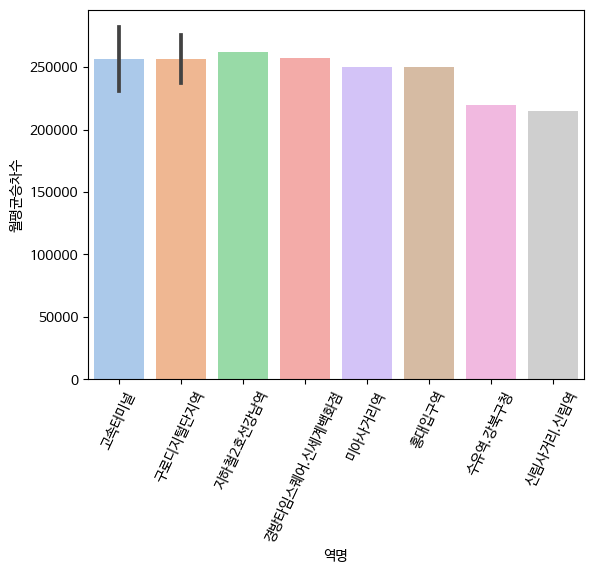

In [25]:
# 역별 승차인구가 가장 많은 역 상위 10개
in_top10 = df_final.sort_values('월평균승차수', ascending=False).head(10)
sns.set_palette('pastel')
sns.barplot(
    data = in_top10,
    x = '역명',
    y = '월평균승차수'
)
plt.xticks(rotation=65)
plt.show()

In [26]:
# 역 위치 시각화
map = folium.Map(location=[37.541, 126.986], zoom_start=12)
for i in range(df_final.shape[0]):
  folium.Marker([df_final['Y좌표'][i], df_final['X좌표'][i]],
                tooltip=df_final['역명'][i]).add_to(map)
map

In [27]:
'''해결중'''
# 이웃 정류소 개수를 구하기
# 정류소의 gps 정보를 가질 새로운 데이터프레임 생성
stop_gps = df_final.copy()
stop_gps

node_id     월평균승차수    월평균하차수              역명         X좌표        Y좌표
0      100000001   13718.33  12643.42         종로2가사거리  126.987750  37.569765
1      100000002   67793.25  60441.75     창경궁.서울대학교병원  126.996566  37.579183
2      100000003  109297.50  77765.50       명륜3가.성대입구  126.998340  37.582671
3      100000004   18956.50  21760.42        종로2가.삼일교  126.987613  37.568579
4      100000005   46090.08  69437.67   혜화동로터리.여운형활동터  127.001744  37.586243
...          ...        ...       ...             ...         ...        ...
10630  124900133    1480.44    390.67         삼익가든아파트  127.148540  37.546305
10631  124900134     111.78   1736.22         삼익가든아파트  127.148832  37.546282
10632  124900135    1446.78    339.67     둔촌신성미소지움아파트  127.144479  37.526743
10633  124900136     269.89   1892.22     둔촌신성미소지움아파트  127.144401  37.526584
10634  124900137   11697.56   3697.67  9호선중앙보훈병원역1번출구  127.147539  37.527911

[10635 rows x 6 columns]

In [33]:
# gps 좌표만들기
latitude = stop_gps['Y좌표'].to_list()
longtitude = stop_gps['X좌표'].to_list()
gps = list(zip(latitude, longtitude))

# 1km 반경 내 주변 이웃정류장 수 구하기

# num_neighbors = []
# for i in tqdm(range(len(gps))):
#   count = 0
#   for j in range(i):
#     distance = haversine(gps[i], gps[j], unit='km')
#     if distance <= 1:
#       count += 1
#   num_neighbors.append(count)

num_neighbors = []
dist_list = []
for i in tqdm(range(len(gps))):
  count = 0
  for j in range(len(gps)):
    if i == j:
        continue;
    dist = haversine(gps[i], gps[j], unit='km')
    dist_list.append(dist)
    if dist <= 1:
      count += 1
  num_neighbors.append(count)


100%|██████████| 10635/10635 [03:33<00:00, 49.90it/s]


In [34]:
# 주변 정류장 수만 잘 구한다면 이웃정류장 목록도 리스트로 포함해서 저장 가능할듯? - 수가 문제네...
np.max(dist_list)

33.96063991448211

In [35]:
stop_gps['주변정류장수(1km)'] = num_neighbors
stop_gps.sort_values('주변정류장수(1km)', ascending=False).head(10)

node_id    월평균승차수   월평균하차수              역명         X좌표        Y좌표  \
1056  103900017    719.33  1543.75  성동중앙교회.벽산아파트정문  127.024579  37.553447   
1071  103900035   1607.58   840.00         벽산아파트정문  127.025045  37.552925   
1178  103900160    748.00   455.17       벽산하이피아상가앞  127.025643  37.552196   
1075  103900040    120.67  1846.50       금호119안전센터  127.024633  37.554146   
1151  103900131    419.58  1797.25     e편한세상금호117동  127.024933  37.552473   
1147  103900125   1566.58  1323.42       금호119안전센터  127.024470  37.554231   
1195  103900181    725.42   592.00        벽산하이피아상가  127.025945  37.551950   
1145  103900123  20766.92  9857.42     행당역.대림아파트정문  127.028672  37.557050   
1019  103000177  11252.67  8391.42             행당역  127.028764  37.557079   
1175  103900157   1135.75  2480.58      벽산아파트111동앞  127.026883  37.553044   

      주변정류장수(1km)  
1056          171  
1071          171  
1178          167  
1075          167  
1151          165  
1147          165  
1195          165  
1145          162  
1019          162  
1175          162